# The Shortcut 3D-Maze Environment
## Author: David Preti, Ph.D. - National Institute for Nuclear Physics (INFN) - 13 Nov 2019

In this 3D-maze environment, the goal is to reach the goal state as fast as possible from the starting state (both defined in maze_env.py). There are 6 actions – up, down, right, left, top, bottom – which take the agent deterministically from a state to the corresponding neighboring states, except when movement is blocked by a wall or the edge of the maze, in which case the agent remains where it is. The reward is +1 on reaching the goal state, 0 otherwise. On reaching the goal state, the agent returns to the start state to being a new episode. This is a discounted, episodic task with $\gamma = 0.95$.

Later, I will use a variant of this maze in which a 'shortcut' opens up after a certain number of timesteps. This code tests if the the Dyna-Q and Dyna-Q+ agents are able to find the newly-opened shorter route to the goal state.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import os, shutil 
from tqdm import tqdm

from rl_glue import RLGlue
from agent import BaseAgent
from maze_env import MazeEnvironment3D, MazeEnvironment3Dshortcut

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

In [3]:
# test env
current_env = MazeEnvironment3D()   # The environment

print('Maze volume = {}'.format(current_env.maze_dim))
print('Maze Wall   = {}'.format(current_env.obstacles))
print('Maze Start  = {}'.format(current_env.start_state))
print('Maze End    = {}'.format(current_env.end_state))

Maze volume = [6, 6, 6]
Maze Wall   = [[0, 2, 0], [1, 2, 0], [2, 2, 0], [3, 2, 0], [4, 2, 0], [5, 2, 0], [0, 2, 1], [1, 2, 1], [2, 2, 1], [3, 2, 1], [4, 2, 1], [5, 2, 1], [0, 2, 2], [1, 2, 2], [2, 2, 2], [3, 2, 2], [4, 2, 2], [5, 2, 2], [0, 2, 3], [1, 2, 3], [2, 2, 3], [3, 2, 3], [4, 2, 3], [5, 2, 3], [0, 2, 4], [1, 2, 4], [2, 2, 4], [4, 2, 4], [5, 2, 4], [0, 2, 5], [1, 2, 5], [2, 2, 5], [4, 2, 5], [5, 2, 5]]
Maze Start  = [2, 0, 0]
Maze End    = [0, 5, 0]


In [4]:
def plot_maze(elev=20.,azim=20.): 

    x, y, z = np.indices(np.array(current_env.maze_dim))
    maze = (x <= x) & (y <=y) & (z <= z) 

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(maze, facecolors='blue', edgecolor=None,alpha = 0.0)

    start_point = (x > current_env.start_state[0] - 1) & (x <= current_env.start_state[0]) & (y > current_env.start_state[1] -1) & (y <= current_env.start_state[1]) & (z > current_env.start_state[2]-1) & (z <= current_env.start_state[2])
    ax.voxels(start_point, facecolors='red', edgecolor='k',alpha = 0.2)

    end_point = (x > current_env.end_state[0] - 1) & (x <= current_env.end_state[0]) & (y > current_env.end_state[1] -1) & (y <= current_env.end_state[1]) & (z > current_env.end_state[2]-1) & (z <= current_env.end_state[2])
    ax.voxels(end_point, facecolors='blue', edgecolor='k',alpha = 0.2)



    for (a,b,c) in current_env.obstacles:
        wall = (x > a - 1) & (x <= a) & (y > b - 1) & (y <= b) & (z > c - 1) & (z <= c)
        ax.voxels(wall, facecolors='green', edgecolor='k',alpha = 0.9)


    #ax.axis("off")
    ax.view_init(elev=elev, azim=azim)
    plt.show()

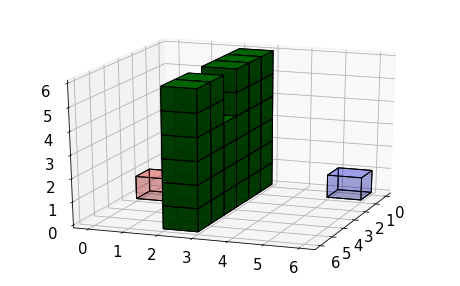

In [5]:
plot_maze()

The red cube is the starting state, while the blue one is the final state. The obstacles are the green blocks forming a wall in the middle of the environment. Notice that there is a opening at the top of the wall which make possible to reach the goal.

In [6]:
class DynaQAgent(BaseAgent):

    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.

        Args:
            agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
            {
                num_states (int): The number of states,
                num_actions (int): The number of actions,
                epsilon (float): The parameter for epsilon-greedy exploration,
                step_size (float): The step-size,
                discount (float): The discount factor,
                planning_steps (int): The number of planning steps per environmental interaction

                random_seed (int): the seed for the RNG used in epsilon-greedy
                planning_random_seed (int): the seed for the RNG used in the planner
            }
        """

        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        # Next, we initialize the attributes required by the agent, e.g., q_values, model, etc.
        # A simple way to implement the model is to have a dictionary of dictionaries, 
        #        mapping each state to a dictionary which maps actions to (reward, next state) tuples.
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {} # model is a dictionary of dictionaries, which maps states to actions to 
                        # (reward, next_state) tuples
                       
    def update_model(self, past_state, past_action, state, reward):
        """updates the model 
        Args:
            past_state       (int): s
            past_action      (int): a
            state            (int): s'
            reward           (int): r
        Returns:
            Nothing
        """
        if past_state in self.model:
            d = {}
            d[past_action] = (state,reward)
            self.model[past_state].update(d)
        else :
            d = {}
            d[past_action] = (state,reward)
            self.model[past_state] = d   
                

    def planning_step(self):
        """performs planning, i.e. indirect RL.
        Args:
            None
        Returns:
            Nothing
        """
        for steps in range(self.planning_steps):
            picked_state = self.planning_rand_generator.choice(list(self.model.keys()))
            picked_action = self.planning_rand_generator.choice(list(self.model[picked_state].keys()))

            (sprime, reward) = self.model[picked_state][picked_action]
            if sprime != -1 :
                self.q_values[picked_state,picked_action] = self.q_values[picked_state,picked_action] + self.step_size* (reward  + self.gamma* np.max(self.q_values[sprime,:]) - self.q_values[picked_state,picked_action])
            else : 
                self.q_values[picked_state,picked_action] = self.q_values[picked_state,picked_action] + self.step_size* ( reward - self.q_values[picked_state,picked_action])

                    
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

    def choose_action_egreedy(self, state):
        """returns an action using an epsilon-greedy policy w.r.t. the current action-value function.
        Important: assume you have a random number generator 'rand_generator' as a part of the class
                    which you can use as self.rand_generator.choice() or self.rand_generator.rand()

        Args:
            state (List): coordinates of the agent (two elements)
        Returns:
            The action taken w.r.t. the aforementioned epsilon-greedy policy
        """

        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.choice(self.actions)
        else:
            values = self.q_values[state]
            action = self.argmax(values)

        return action        
        
        
    def agent_start(self, state):
        """The first method called when the experiment starts, 
        called after the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's env_start function.
        Returns:
            (int) the first action the agent takes.
        """
        self.past_state = state
        self.past_action = self.choose_action_egreedy(state) 

        return self.past_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based on where the agent ended up after the
                last step
        Returns:
            (int) The action the agent takes given this state.
        """

        self.q_values[self.past_state,self.past_action] = self.q_values[self.past_state,self.past_action] + self.step_size* (reward  + self.gamma* np.max(self.q_values[state,:]) - self.q_values[self.past_state,self.past_action])
        self.update_model(self.past_state, self.past_action, state, reward)
        self.planning_step()
        self.past_action = self.choose_action_egreedy(state)
        self.past_state = state

        return self.past_action

    def agent_end(self, reward):
        """Called when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        self.q_values[self.past_state,self.past_action] = self.q_values[self.past_state,self.past_action] + self.step_size* (reward  + self.gamma* np.max(self.q_values[-1,:]) - self.q_values[self.past_state,self.past_action])
        self.update_model(self.past_state, self.past_action, -1, reward)
        self.planning_step()
        

In [7]:
def run_experiment(env, agent, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_episodes = exp_parameters['num_episodes']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = env_parameters                     
    agent_info = {"num_states" : agent_parameters["num_states"],  # We pass the agent the information it needs. 
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    all_averages = np.zeros((len(planning_steps_all), num_runs, num_episodes)) # for collecting metrics 
    log_data = {'planning_steps_all' : planning_steps_all}                     # that shall be plotted later

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 0.5')                    # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  

        for i in tqdm(range(num_runs)):

            agent_info['random_seed'] = i
            agent_info['planning_random_seed'] = i

            rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            for j in range(num_episodes):

                rl_glue.rl_start()                # We start an episode. Here we aren't using rl_glue.rl_episode()
                                                  # like the other assessments because we'll be requiring some 
                is_terminal = False               # data from within the episodes in some of the experiments here 
                num_steps = 0
                while not is_terminal:
                    reward, _, action, is_terminal = rl_glue.rl_step()  # The environment and agent take a step 
                    num_steps += 1                                      # and return the reward and action taken.

                all_averages[idx][i][j] = num_steps

    log_data['all_averages'] = all_averages
    np.save("results/Dyna-Q_planning_steps", log_data)
    

def plot_steps_per_episode(file_path):

    data = np.load(file_path,allow_pickle=True).item()
    all_averages = data['all_averages']
    planning_steps_all = data['planning_steps_all']

    for i, planning_steps in enumerate(planning_steps_all):
        plt.plot(np.mean(all_averages[i], axis=0), label='Planning steps = '+str(planning_steps))

    plt.legend(loc='upper right')
    plt.xlabel('Episodes')
    plt.ylabel('Steps\nper\nepisode', rotation=0, labelpad=40)
    plt.axhline(y=16, linestyle='--', color='grey', alpha=0.4)
    plt.show()

In [8]:
nstates = 6*6*6

Planning steps :  0


100%|██████████| 10/10 [00:03<00:00,  2.23it/s]


Planning steps :  10


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Planning steps :  20


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


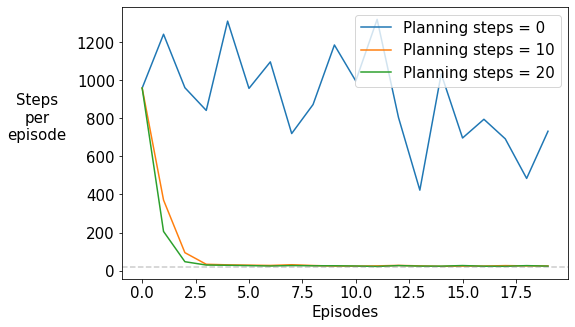

In [9]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 10,                     # The number of times we run the experiment
    "num_episodes" : 20,                 # The number of episodes per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
}

# Agent parameters
agent_parameters = {  
    "num_states" : nstates,
    "num_actions" : 6, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [0, 10, 20]       # The list of planning_steps we want to try
}

current_env =  MazeEnvironment3D   # The environment
current_agent = DynaQAgent              # The agent

run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_steps_per_episode('results/Dyna-Q_planning_steps.npy')  

Great! Planning seems to improve incredibly the speed at wich the agent find the (quasi) optimal policy. 

Let me consider now a small variation of the environment with a shortcut that opens at a specific timestep:

In [10]:
def run_experiment_with_state_visitations(env, agent, env_parameters, agent_parameters, exp_parameters, result_file_name):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = {"change_at_n" : env_parameters["change_at_n"]}                     
    agent_info = {"num_states" : agent_parameters["num_states"],  
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    state_visits_before_change = np.zeros((len(planning_steps_all), num_runs, 6*6*6))  # For saving the number of
    state_visits_after_change = np.zeros((len(planning_steps_all), num_runs, 6*6*6))   #     state-visitations 
    cum_reward_all = np.zeros((len(planning_steps_all), num_runs, num_max_steps))   # For saving the cumulative reward
    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 1')          # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  # We pass the agent the information it needs. 

        for run in tqdm(range(num_runs)):

            agent_info['random_seed'] = run
            agent_info['planning_random_seed'] = run

            rl_glue = RLGlue(env, agent)  # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :

                state, _ = rl_glue.rl_start()  # We start the experiment. We'll be collecting the 
                is_terminal = False            # state-visitation counts to visiualize the learned policy
                if num_steps < env_parameters["change_at_n"]: 
                    state_visits_before_change[idx][run][state] += 1
                else:
                    state_visits_after_change[idx][run][state] += 1

                while not is_terminal and num_steps < num_max_steps-1 :
                    reward, state, action, is_terminal = rl_glue.rl_step()  
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[idx][run][num_steps] = cum_reward
                    if num_steps < env_parameters["change_at_n"]:
                        state_visits_before_change[idx][run][state] += 1
                    else:
                        state_visits_after_change[idx][run][state] += 1

    log_data['state_visits_before'] = state_visits_before_change
    log_data['state_visits_after'] = state_visits_after_change
    log_data['cum_reward_all'] = cum_reward_all
    np.save("results/" + result_file_name, log_data)

def plot_cumulative_reward(file_path, item_key, y_key, y_axis_label, legend_prefix, title, change_env):

    data_all = np.load(file_path, allow_pickle=True).item()
    data_y_all = data_all[y_key]
    items = data_all[item_key]

    for i, item in enumerate(items):
        plt.plot(np.mean(data_y_all[i], axis=0), label=legend_prefix+str(item))

    plt.axvline(x=change_env, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel(y_axis_label, rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

Planning steps :  40


100%|██████████| 50/50 [09:44<00:00, 10.00s/it]


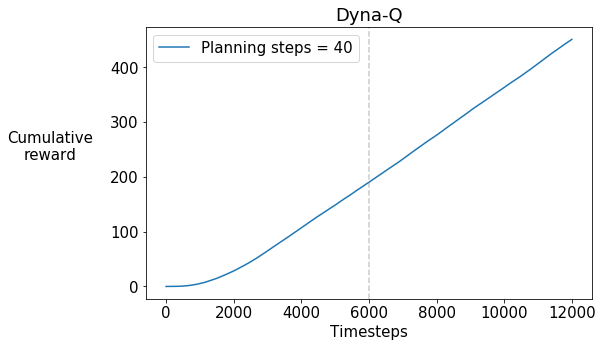

In [11]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 50,                     # The number of times we run the experiment
    "num_max_steps" : 12000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 6000
}

# Agent parameters
agent_parameters = {  
    "num_states" : nstates,
    "num_actions" : 6, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [40]      # The list of planning_steps we want to try
}

current_env = MazeEnvironment3Dshortcut   # The environment
current_agent = DynaQAgent              # The agent

run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q_shortcut_steps")    
plot_cumulative_reward('results/Dyna-Q_shortcut_steps.npy', 'planning_steps_all', 'cum_reward_all', 'Cumulative\nreward', 'Planning steps = ', 'Dyna-Q', environment_parameters["change_at_n"])

As it is possible to notice here, an optimal policy is found before the shortcut is opened (denoted by dotted vertical line in the plot above). However, the algorithm is not able to adapt the policy to the new environment... as expected by Dyna-Q algorithm! 

In [12]:
def plot_state_visitations_comparison(old_env, new_env, file_path, plot_titles, idx, el=20., az=20.):

    data_keys = ["state_visits_before", "state_visits_after"]
    positions = [211,212]
    titles = plot_titles
    
    for i in range(2):
        if i==0:
            current_env = old_env
        else :
            current_env = new_env
            current_env.obstacles = [[0, 2, 0], [1, 2, 0], [2, 2, 0],            [4, 2, 0], [5, 2, 0],
                              [0, 2, 1], [1, 2, 1], [2, 2, 1], [3, 2, 1], [4, 2, 1], [5, 2, 1],
                              [0, 2, 2], [1, 2, 2], [2, 2, 2], [3, 2, 2], [4, 2, 2], [5, 2, 2],
                              [0, 2, 3], [1, 2, 3], [2, 2, 3], [3, 2, 3], [4, 2, 3], [5, 2, 3],
                              [0, 2, 4], [1, 2, 4], [2, 2, 4]           , [4, 2, 4], [5, 2, 4],
                              [0, 2, 5], [1, 2, 5], [2, 2, 5]           , [4, 2, 5], [5, 2, 5]]
            
            
        x, y, z = np.indices(np.array(current_env.maze_dim));
        maze = (x <= x) & (y <=y) & (z <= z) 

        fig = plt.figure()
        
        ax = fig.gca(projection='3d')
        ax.voxels(maze, facecolors='blue', edgecolor=None,alpha = 0.0)

        start_point = (x > current_env.start_state[0] - 1) & (x <= current_env.start_state[0]) & (y > current_env.start_state[1] -1) & (y <= current_env.start_state[1]) & (z > current_env.start_state[2]-1) & (z <= current_env.start_state[2])
        ax.voxels(start_point, facecolors='red', edgecolor='k',alpha = 0.2)

        end_point = (x > current_env.end_state[0] - 1) & (x <= current_env.end_state[0]) & (y > current_env.end_state[1] -1) & (y <= current_env.end_state[1]) & (z > current_env.end_state[2]-1) & (z <= current_env.end_state[2])
        ax.voxels(end_point, facecolors='blue', edgecolor='k',alpha = 0.2)

        for (a,b,c) in current_env.obstacles:
            wall = (x > a - 1) & (x <= a) & (y > b - 1) & (y <= b) & (z > c - 1) & (z <= c)
            ax.voxels(wall, facecolors='green', edgecolor='k',alpha = 0.9)

        data = np.load(file_path, allow_pickle=True).item()
        titles = plot_titles
        #wall_ends = [None,-1]
        state_visits = data[data_keys[i]][idx]
        average_state_visits = np.mean(state_visits, axis=0)
        grid_state_visits = average_state_visits.reshape((6,6,6)).T
        grid_state_visits_normed = grid_state_visits / (np.linalg.norm(grid_state_visits) + 1e-16)


        for a in range(6):
            for b in range(6):
                for c in range(6):
                    visits = (x > a - 1) & (x <= a) & (y > b - 1) & (y <= b) & (z > c - 1) & (z <= c)
                    ax.voxels(visits, facecolors='purple', edgecolor=None ,alpha = grid_state_visits_normed[a,b,c])
        
        plt.title(titles[i]) 
        ax.view_init(elev=el, azim=az) 
    plt.show()

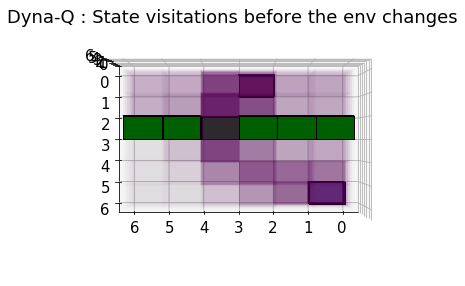

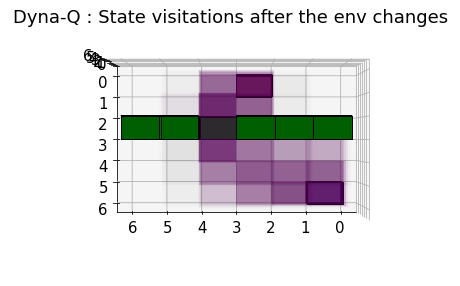

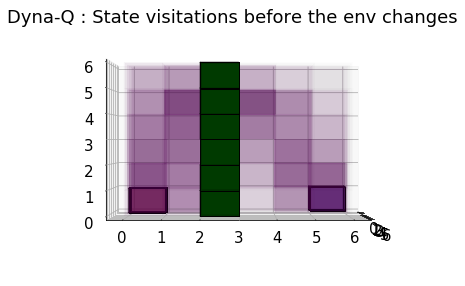

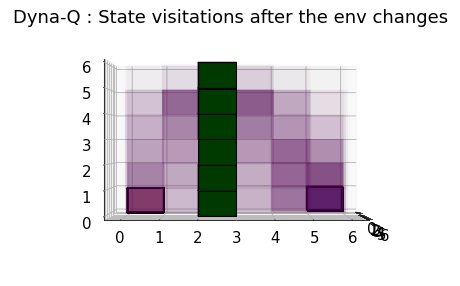

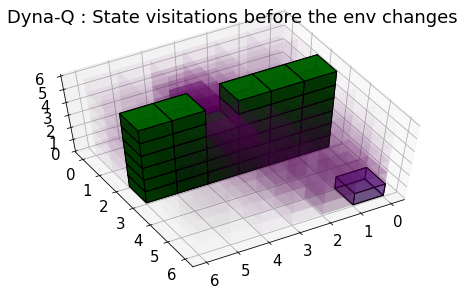

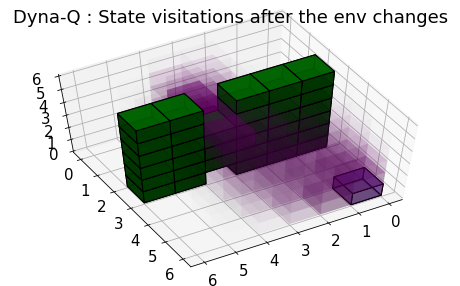

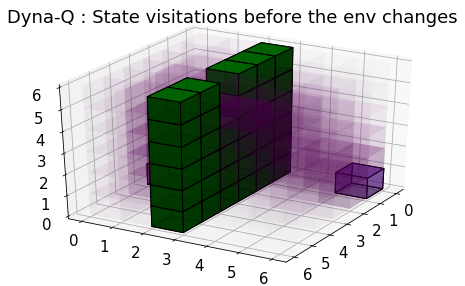

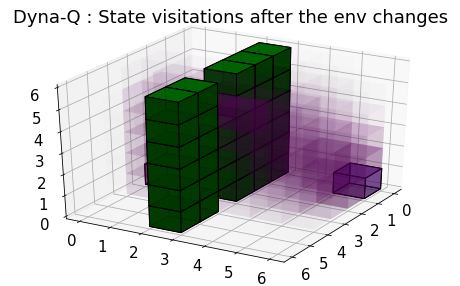

In [13]:
plot_state_visitations_comparison(MazeEnvironment3D(),MazeEnvironment3Dshortcut(),"results/Dyna-Q_shortcut_steps.npy", ['Dyna-Q : State visitations before the env changes', 'Dyna-Q : State visitations after the env changes'], 0, 90, 90)
plot_state_visitations_comparison(MazeEnvironment3D(),MazeEnvironment3Dshortcut(),"results/Dyna-Q_shortcut_steps.npy", ['Dyna-Q : State visitations before the env changes', 'Dyna-Q : State visitations after the env changes'], 0, 0, 0)
plot_state_visitations_comparison(MazeEnvironment3D(),MazeEnvironment3Dshortcut(),"results/Dyna-Q_shortcut_steps.npy", ['Dyna-Q : State visitations before the env changes', 'Dyna-Q : State visitations after the env changes'], 0, 60, 60)
plot_state_visitations_comparison(MazeEnvironment3D(),MazeEnvironment3Dshortcut(),"results/Dyna-Q_shortcut_steps.npy", ['Dyna-Q : State visitations before the env changes', 'Dyna-Q : State visitations after the env changes'], 0, 30, 30)

As anticipated, the agent is not able to optimize the policy after the change of environment! However, Dyna-Q is behaving very well!

Let's try a Dyna-Q+, which should fix this problem by enhancing the exploration during the planning phase and hence discover the shortcut. 

In [14]:
class DynaQPlusAgent(BaseAgent):
    
    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.

        Args:
            agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
            {
                num_states (int): The number of states,
                num_actions (int): The number of actions,
                epsilon (float): The parameter for epsilon-greedy exploration,
                step_size (float): The step-size,
                discount (float): The discount factor,
                planning_steps (int): The number of planning steps per environmental interaction
                kappa (float): The scaling factor for the reward bonus

                random_seed (int): the seed for the RNG used in epsilon-greedy
                planning_random_seed (int): the seed for the RNG used in the planner
            }
        """
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)
        self.kappa = agent_info.get("kappa", 0.0005) #0.001

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.tau = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {}
        
        
    def update_model(self, past_state, past_action, state, reward):
        """updates the model 

        Args:
            past_state  (int): s
            past_action (int): a
            state       (int): s'
            reward      (int): r
        Returns:
            Nothing
        """
        if past_state not in self.model:
            self.model[past_state] = {past_action : (state, reward)}
            for action in self.actions:
                if action != past_action:
                    self.model[past_state][action] = (past_state, 0)  
        else:
            self.model[past_state][past_action] = (state, reward)

            
    def planning_step(self):
        """performs planning, i.e. indirect RL.

        Args:
            None
        Returns:
            Nothing
        """
        for steps in range(self.planning_steps):

            picked_state = self.planning_rand_generator.choice(list(self.model.keys()))
            picked_action = self.planning_rand_generator.choice(list(self.model[picked_state].keys()))

            (sprime, reward) = self.model[picked_state][picked_action]
            reward += self.kappa*np.sqrt(self.tau[picked_state,picked_action])
            if sprime != -1 :
                self.q_values[picked_state,picked_action] = self.q_values[picked_state,picked_action] + self.step_size* (reward  + self.gamma* np.max(self.q_values[sprime,:]) - self.q_values[picked_state,picked_action])
            else : 
                self.q_values[picked_state,picked_action] = self.q_values[picked_state,picked_action] + self.step_size* ( reward - self.q_values[picked_state,picked_action])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

    def choose_action_egreedy(self, state):
        """returns an action using an epsilon-greedy policy w.r.t. the current action-value function.

        Important: assume you have a random number generator 'rand_generator' as a part of the class
                    which you can use as self.rand_generator.choice() or self.rand_generator.rand()

        Args:
            state (List): coordinates of the agent (two elements)
        Returns:
            The action taken w.r.t. the aforementioned epsilon-greedy policy
        """

        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.choice(self.actions)
        else:
            values = self.q_values[state]
            action = self.argmax(values)

        return action       
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's env_start function.
        Returns:
            (int) The first action the agent takes.
        """
        self.past_state=state
        self.past_action=self.choose_action_egreedy(state)
        
        return self.past_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based on where the agent ended up after the
                last step
        Returns:
            (int) The action the agent is taking.
        """  

        self.tau = self.tau + 1
        self.tau[self.past_state, self.past_action] = 0

        self.q_values[self.past_state,self.past_action] = self.q_values[self.past_state,self.past_action] + self.step_size* (reward  + self.gamma* np.max(self.q_values[state,:]) - self.q_values[self.past_state,self.past_action])
        self.update_model(self.past_state, self.past_action, state, reward)
        self.planning_step()
        self.past_action = self.choose_action_egreedy(state)
        self.past_state = state    

        return self.past_action

    def agent_end(self, reward):
        """Called when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.tau = self.tau + 1
        self.tau[self.past_state, self.past_action] = 0

        self.q_values[self.past_state,self.past_action] = self.q_values[self.past_state,self.past_action] + self.step_size* (reward  - self.q_values[self.past_state,self.past_action])
        self.update_model(self.past_state, self.past_action, -1, reward)
        self.planning_step()    


In [15]:

# Experiment parameters
experiment_parameters = {
    "num_runs" : 50,                     # The number of times we run the experiment
    "num_max_steps" : 12000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 6000
}

# Agent parameters
agent_parameters = {  
    "num_states" : nstates,
    "num_actions" : 6, 
    "epsilon": 0.1, 
    "step_size" : 0.5,
    "planning_steps" : [40],      
}

current_env = MazeEnvironment3Dshortcut   # The environment
current_agent = DynaQPlusAgent          # The agent

run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q+")

Planning steps :  40


100%|██████████| 50/50 [09:45<00:00, 11.55s/it]


In [16]:
def plot_cumulative_reward_comparison(file_name_dynaq, file_name_dynaqplus, change_env):

    cum_reward_q = np.load(file_name_dynaq,allow_pickle=True).item()['cum_reward_all'][0]
    cum_reward_qPlus = np.load(file_name_dynaqplus,allow_pickle=True).item()['cum_reward_all'][0]

    plt.plot(np.mean(cum_reward_qPlus, axis=0), label='Dyna-Q+')
    plt.plot(np.mean(cum_reward_q, axis=0), label='Dyna-Q')

    plt.axvline(x=change_env, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative\nreward', rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title('Average performance of Dyna-Q and Dyna-Q+ agents in the Shortcut Maze\n')
    plt.show()

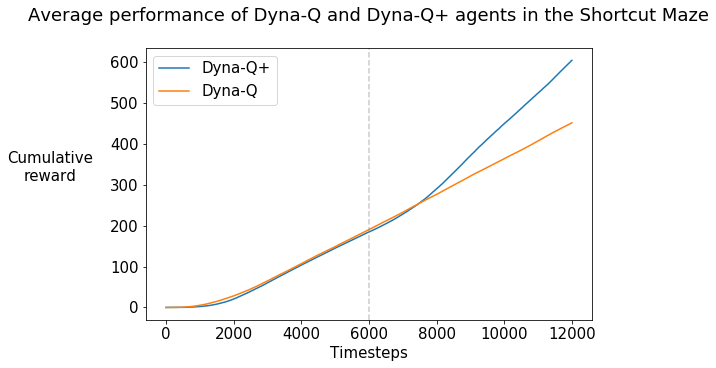

In [17]:
plot_cumulative_reward_comparison('results/Dyna-Q_shortcut_steps.npy', 'results/Dyna-Q+.npy', environment_parameters["change_at_n"])

Dyna-Q+ is sensitive to the evironment change and adapt to the shortcut! 

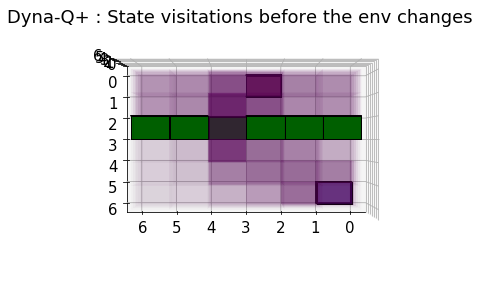

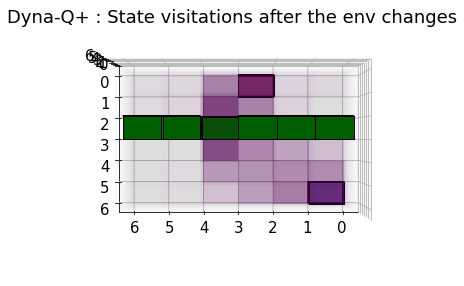

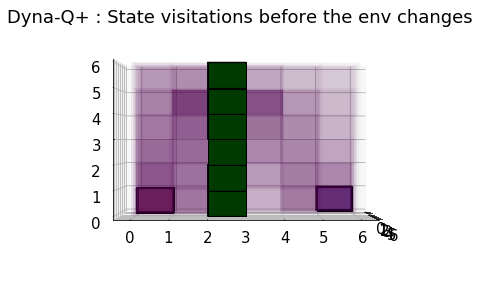

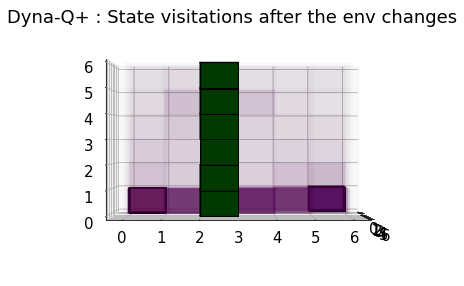

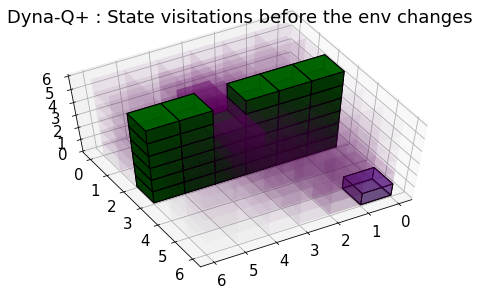

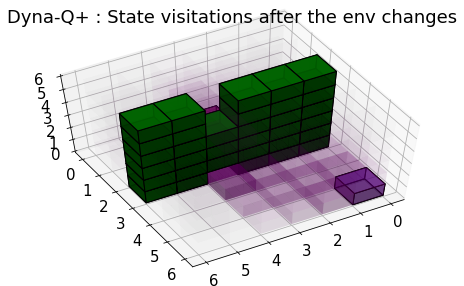

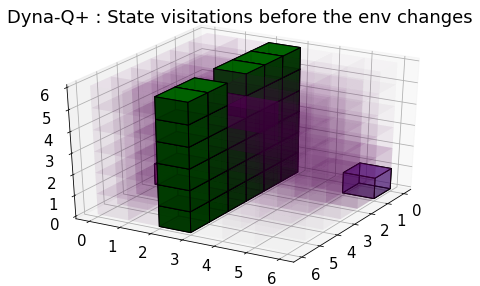

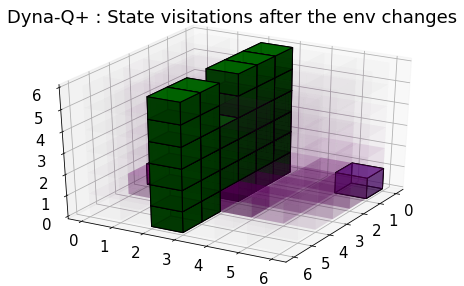

In [18]:
plot_state_visitations_comparison(MazeEnvironment3D(),MazeEnvironment3Dshortcut(),"results/Dyna-Q+.npy", ['Dyna-Q+ : State visitations before the env changes', 'Dyna-Q+ : State visitations after the env changes'], 0, 90, 90)
plot_state_visitations_comparison(MazeEnvironment3D(),MazeEnvironment3Dshortcut(),"results/Dyna-Q+.npy", ['Dyna-Q+ : State visitations before the env changes', 'Dyna-Q+ : State visitations after the env changes'], 0, 0, 0)
plot_state_visitations_comparison(MazeEnvironment3D(),MazeEnvironment3Dshortcut(),"results/Dyna-Q+.npy", ['Dyna-Q+ : State visitations before the env changes', 'Dyna-Q+ : State visitations after the env changes'], 0, 60, 60)
plot_state_visitations_comparison(MazeEnvironment3D(),MazeEnvironment3Dshortcut(),"results/Dyna-Q+.npy", ['Dyna-Q+ : State visitations before the env changes', 'Dyna-Q+ : State visitations after the env changes'], 0, 30, 30)

Everything works as expected! 